In [1]:
from Community import *
import networkx as nx
import igraph as ig

## Funciones auxiliares

In [2]:
def plot_weights(G,ax,c=0.98,label='sci'):
    W = np.array([d['weight'] for u,v,d in G.edges(data = True)])
    W = np.round(W,4)
    w_c = np.quantile(W,c)
    n_edges = len(W[W>=w_c])
    values,count = np.unique(W,return_counts = True)
    count = count/np.sum(count)
    ax.axvline(w_c,label=f'Cuartil {c}',linestyle='dashed')
    ax.loglog(values,count,'.',label=label)
    ax.text(values[-40],count[2],f'No. vinculos : {n_edges}')
    ax.set_ylabel('P(w)')
    ax.set_xlabel('w')
    ax.legend()

In [3]:
file = open("cie2.txt","r",encoding="utf8")
X = []

while True:
	content=file.readline()
	if not content:
		break
	X.append(content)
file.close()
import re

def contains_two_numbers(string):
    pattern = r'^[^0-9]*[0-9][0-9][^0-9]*$'
    return bool(re.match(pattern, string))
D1 = [x for x in X if contains_two_numbers(x)]
dic = {s.split()[0].replace('*',''):" ".join(s.split()[1:]).replace('*','') for s in D1 if len(s.split())>1}
dic['K64'] = 'hemorroides y trombosis venosa perianal'

In [4]:
def draw_communities_k(G2,comm_dict,ax,k = 5,order = True):
    G = G2.copy()
    w = [d['weight'] for u,v,d in G.edges(data=True)]
    val_c = np.quantile(w,0.98)
    G.remove_edges_from([(u,v) for u,v,d in G.edges(data=True) if d['weight']<val_c])
    G.remove_nodes_from([u for u in G.nodes() if nx.degree(G,u)==0])
    conver_label = {j:u for j,u in enumerate(G.nodes())}
    for ke in comm_dict.keys():
        comm_dict[ke] = [conver_label[u] for u in comm_dict[ke]]
    comm_dict_reduce = dict()
    lens = [(d,len(comm_dict[d])) for d in comm_dict.keys() if len(comm_dict[d])>3]
    lens.sort(key=lambda x:x[1])
    if order:
        comm_dict_reduce = {ke[0]:comm_dict[ke[0]] for ke in lens[-k:]}
    else:
        keys_aux = [k for k in comm_dict.keys() if len(comm_dict[k])>3]
        comm_dict_reduce = {ke:comm_dict[ke] for ke in list(keys_aux)[-k:]}
    all_nodes = list(comm_dict_reduce.values())
    nodes = []
    for a in all_nodes:
        nodes += [x for x in a]
    nodes_not_in_k = [u for u in G.nodes() if u not in nodes]
    G.remove_nodes_from(nodes_not_in_k)
    draw_communities(G, comm_dict_reduce,ax)
    return comm_dict_reduce

## Redes

In [5]:
params = {
    'k' : 5,
    'order' : False,
    'model' : 'RB',
    'resolution_parameter' : 1.8 #solo aplica para modelo RB y de potts
}

def generate_results(filepath_sci,filepath_cij,label):
    G_cij = nx.read_graphml(filepath_cij)
    G_sci = nx.read_graphml(filepath_sci)
    fig,(ax1,ax2) = plt.subplots(2)
    plot_weights(G_sci,ax=ax1)
    plot_weights(G_cij,ax=ax2,label='cij')
    plt.suptitle(label)
    plt.show()
    model = params.get('model',None)
    if model == 'Classic':
        comm_dict_sci = communities(G = G_sci,weighted=True)
        comm_dict_cij = communities(G = G_cij,weighted=True)
    else:
        comm_dict_sci = communities(G = G_sci,weighted=True,model = params.get('model',None),resolution_parameter =  params.get('res_param',1.0))
        comm_dict_cij = communities(G = G_cij,weighted=True,model = params.get('model',None),resolution_parameter =  params.get('res_param',1.0))
    fig,ax = plt.subplots(figsize=(16,16))
    nodes = [u for u in G_sci.nodes() if G_sci.degree(u)==0]
    pos = nx.spring_layout(G_sci,scale=30)
    nx.draw_networkx_nodes(G_sci,nodelist=nodes,ax=ax,pos=pos,node_size=8,label='Nodos Aislados')
    comm_dict_reduce_sci = draw_communities_k(G_sci,comm_dict_sci,ax,k = params.get('k',3),order= params.get('order',False))
    ax.legend()

    fig,ax = plt.subplots(figsize=(16,16))
    nodes = [u for u in G_cij.nodes() if G_sci.degree(u)==0]
    pos = nx.spring_layout(G_cij,scale=30)
    nx.draw_networkx_nodes(G_cij,nodelist=nodes,ax=ax,pos=pos,node_size=8,label='Nodos Aislados')
    comm_dict_reduce_cij = draw_communities_k(G_cij,comm_dict_cij,ax,k = params.get('k',3),order= params.get('order',False))
    ax.legend()


    # Assuming `dic`, `label`, `comm_dict_reduce_sci`, and `comm_dict_reduce_cij` are defined

    with open("comunidades.txt", "a") as f:
        f.write("---------------------")
        f.write(f"Población: {label}\n")
        f.write("---------------------")
        f.write('MODELO SCI\n')
    
        for k, i in comm_dict_reduce_sci.items():
            f.write(f"Comunidad {k}\n")
            f.write('----------------------------\n')
            for ii in i:
                f.write(f"{dic[ii]}\n")

        f.write("\n")
        f.write('MODELO CIJ\n')
    
        for k, i in comm_dict_reduce_cij.items():
            f.write(f"Comunidad {k}\n")
            f.write('----------------------------\n')
            for ii in i:
                f.write(f"{dic[ii]}\n")

    return

### Femenino Subsidiado 40-60

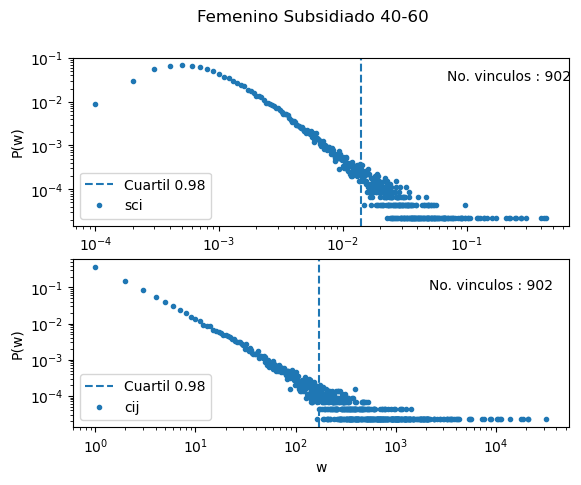

Numero nodos iniciales :  1372
Numero vinculos iniciales :  44948
Numero nodos finales:  345
Numero vinculos finales :  899
Modularidad
0.6194888400286568
Numero nodos iniciales :  1372
Numero vinculos iniciales :  44948
Numero nodos finales:  166
Numero vinculos finales :  902
Modularidad
0.2649993117044655


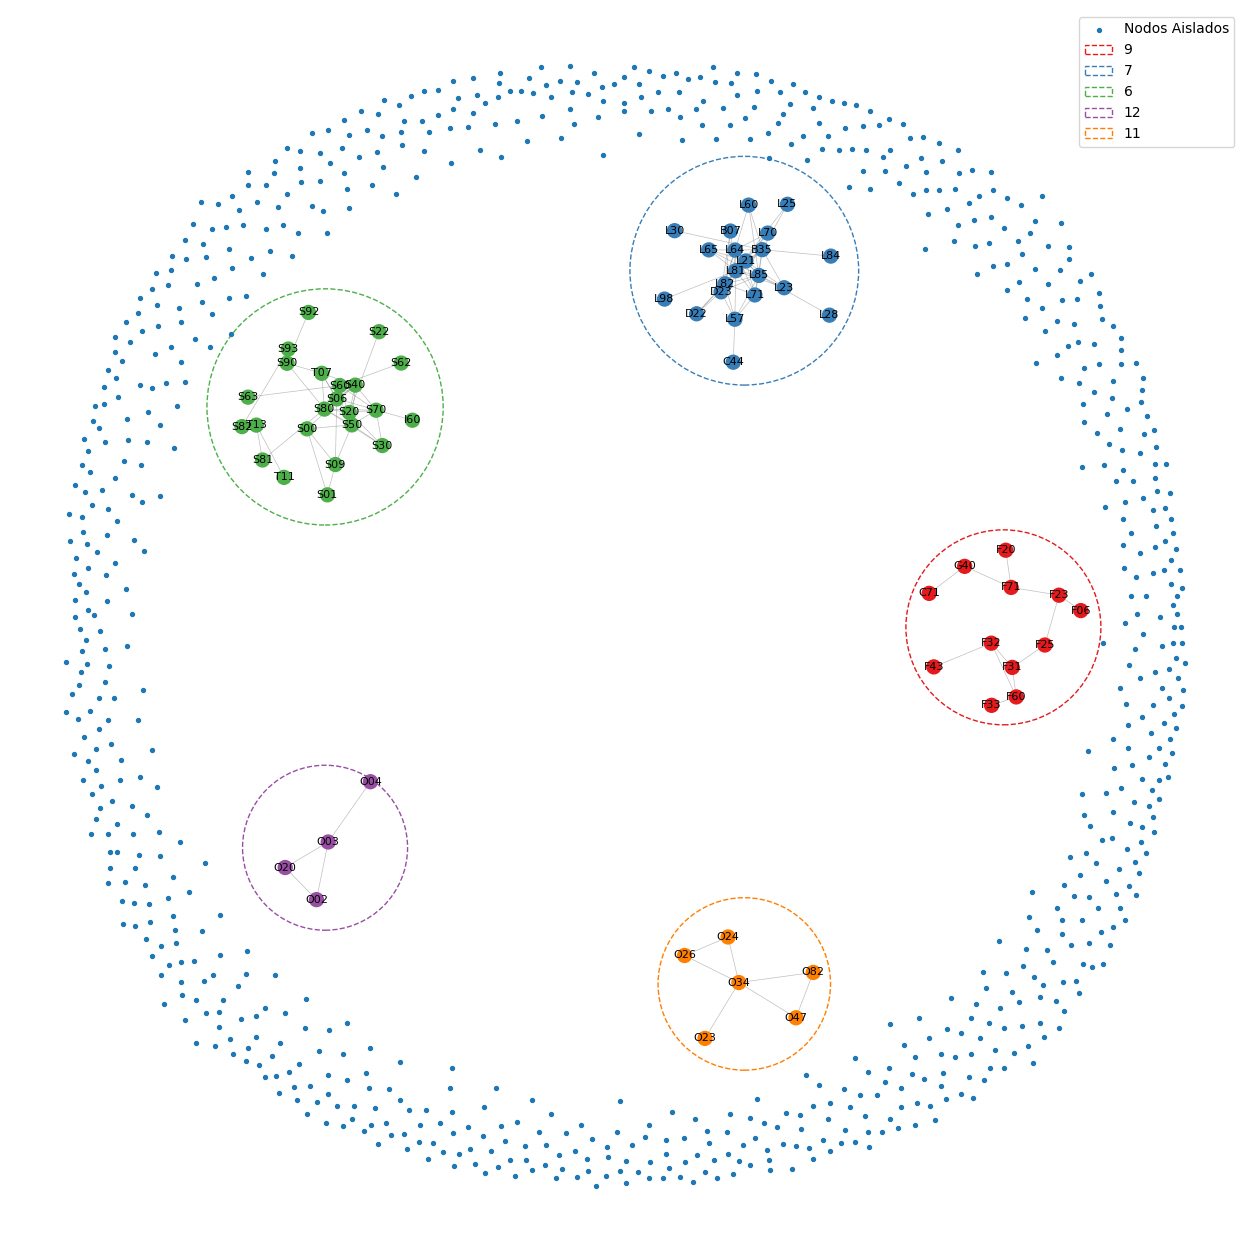

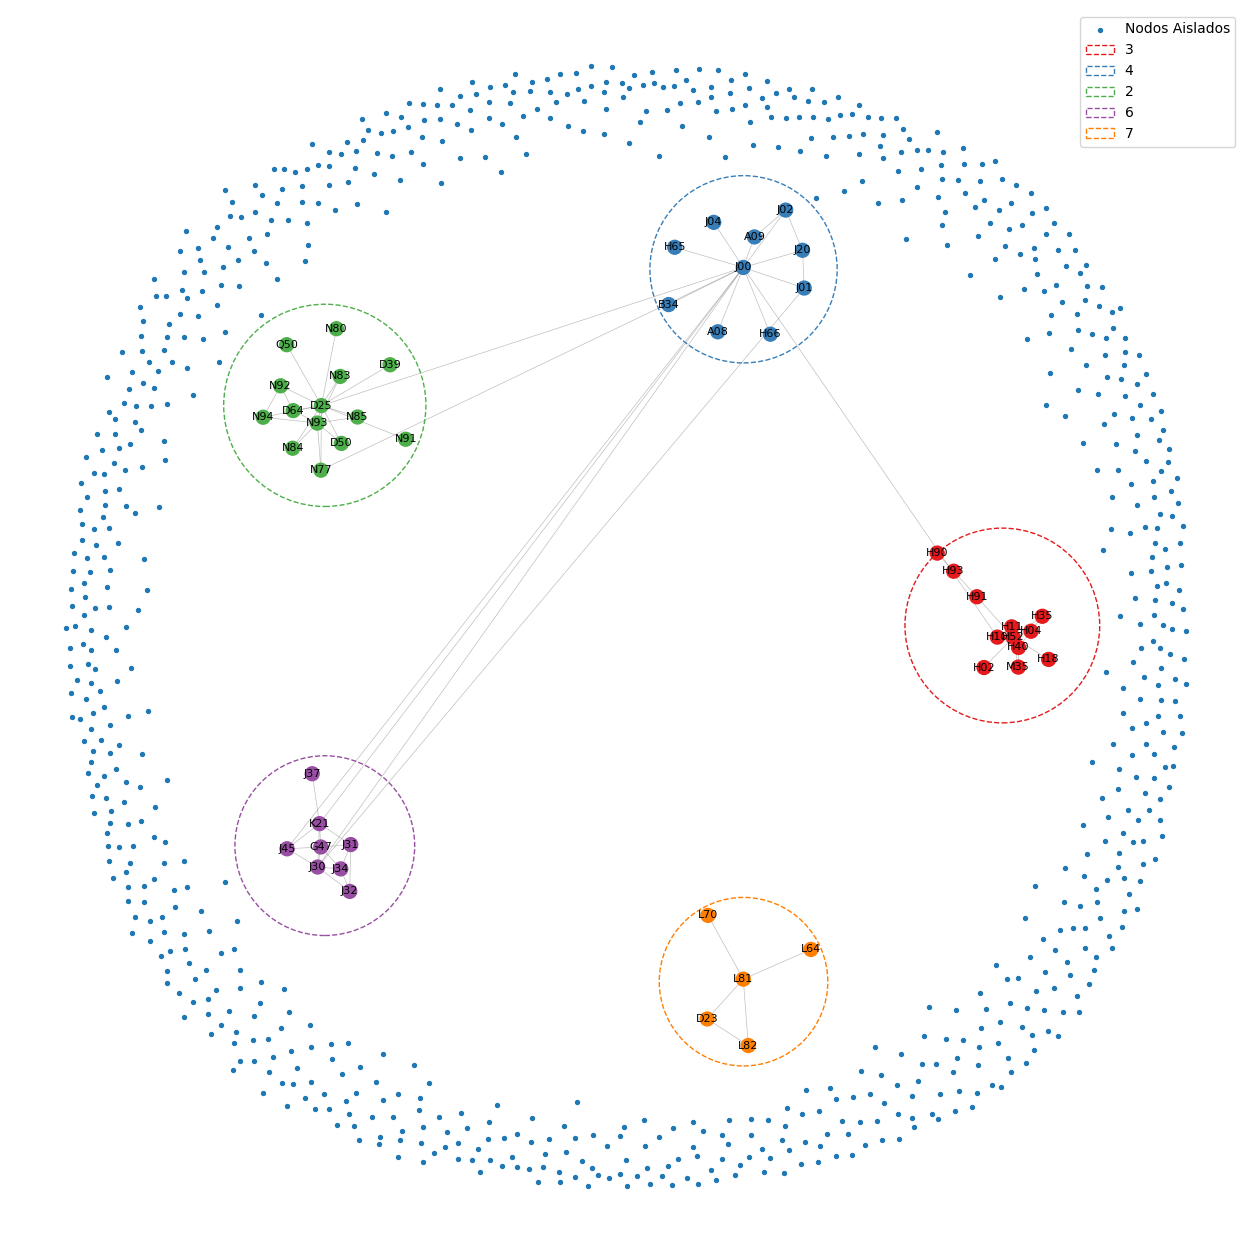

In [6]:
generate_results('redes/graph_sci_F1_40.graphml','redes/graph_cij_F1_40.graphml',label = 'Femenino Subsidiado 40-60')

### Femenino Contributivo 40-60

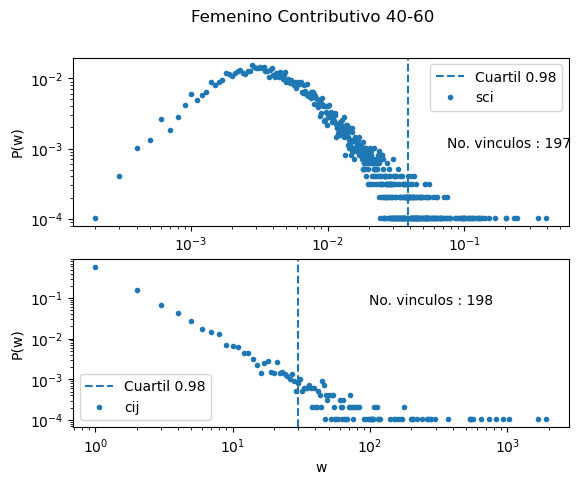

Numero nodos iniciales :  1083
Numero vinculos iniciales :  9736
Numero nodos finales:  208
Numero vinculos finales :  195
Modularidad
0.9368047337278097
Numero nodos iniciales :  1083
Numero vinculos iniciales :  9736
Numero nodos finales:  65
Numero vinculos finales :  198
Modularidad
0.2805198449137843


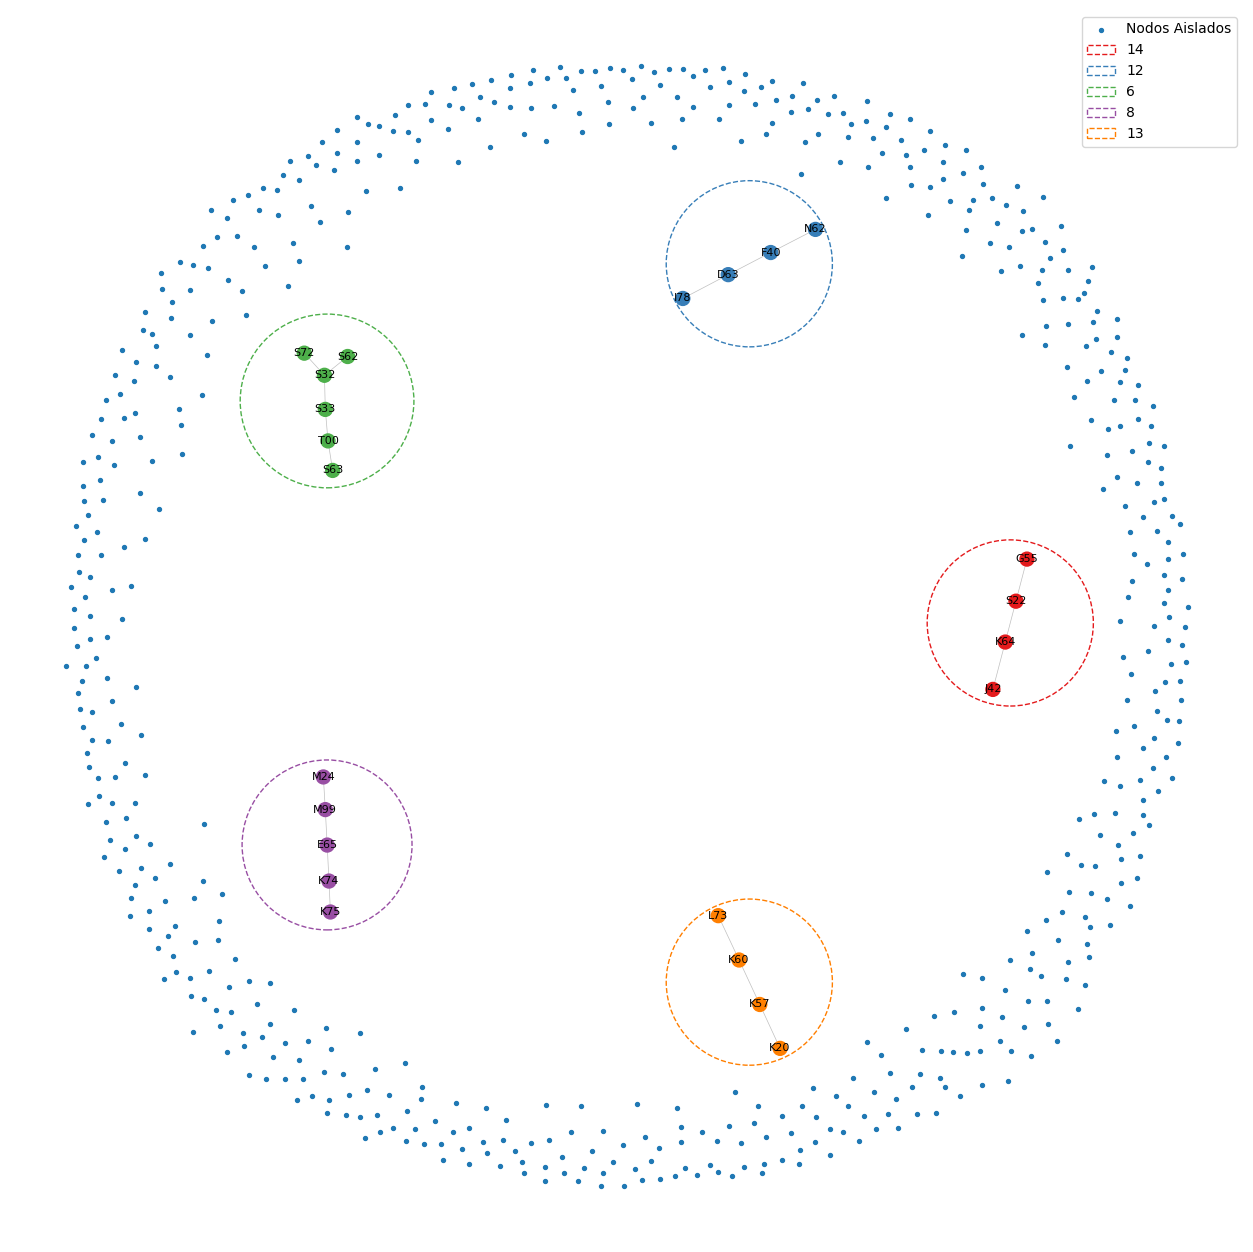

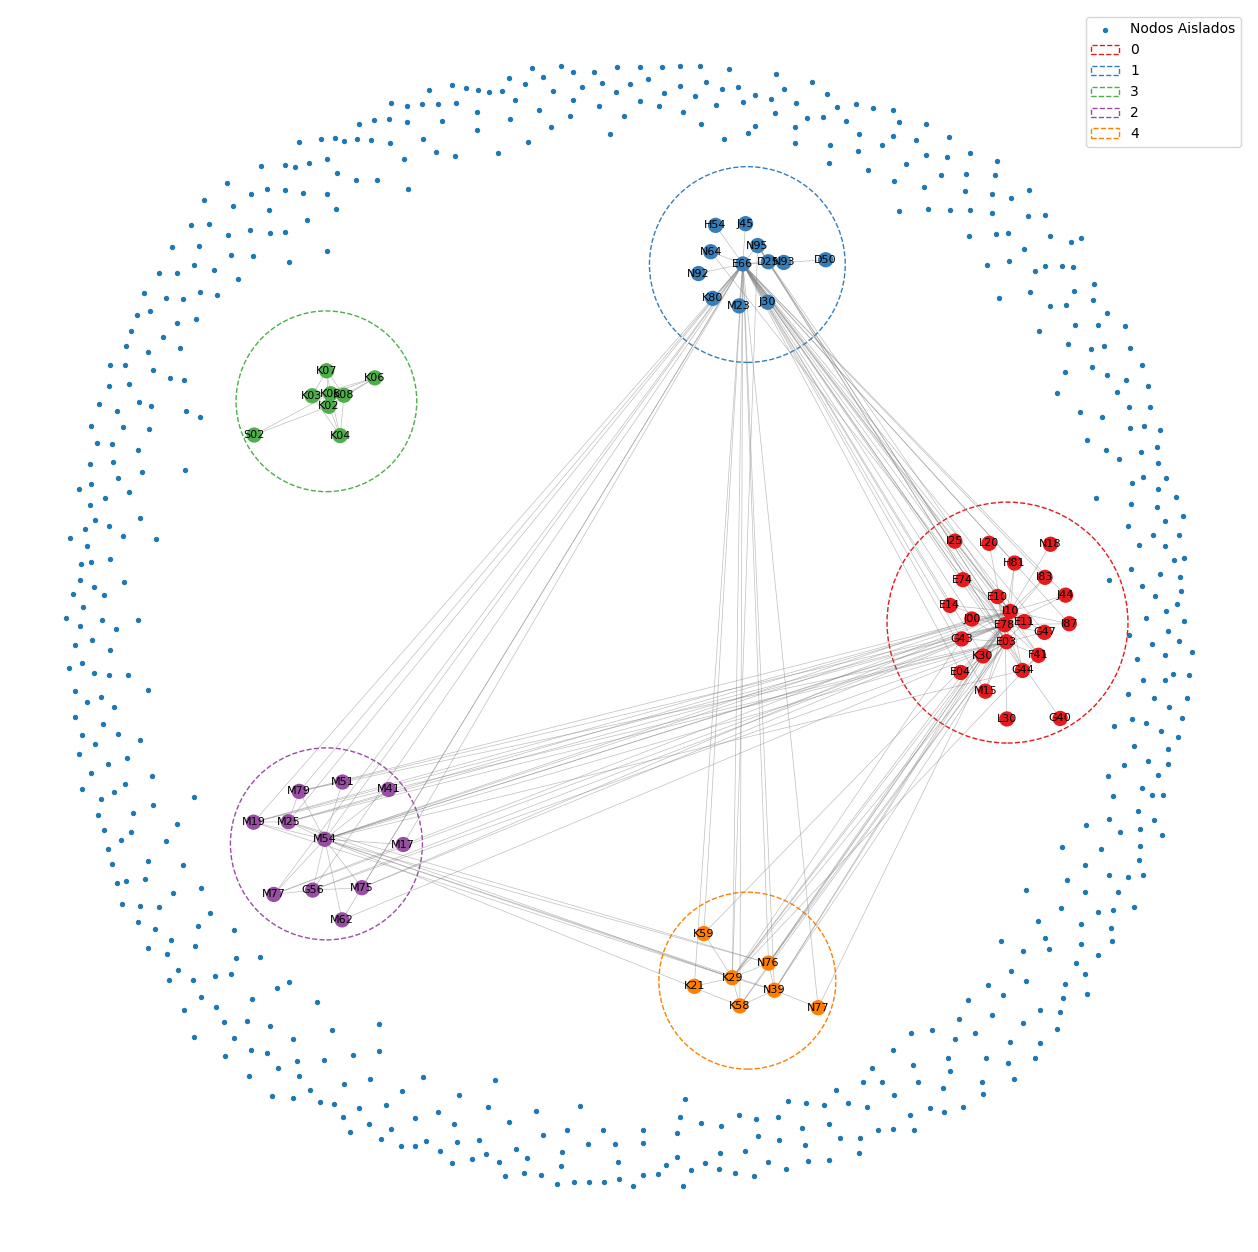

In [7]:
generate_results('redes/graph_sci_F2_40.graphml','redes/graph_cij_F2_40.graphml',label = 'Femenino Contributivo 40-60')

### Femenino Subsidiado >60

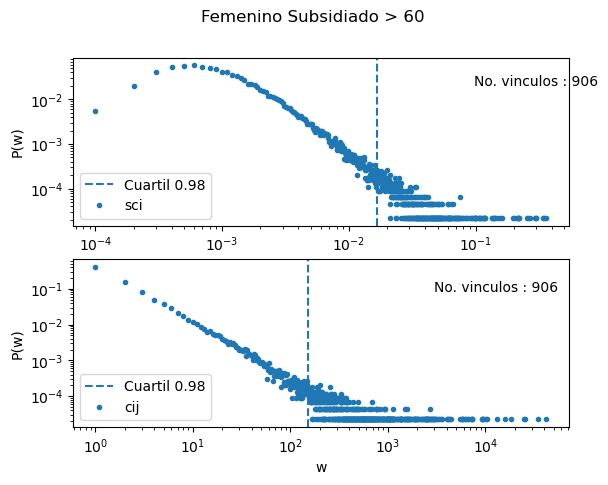

Numero nodos iniciales :  1292
Numero vinculos iniciales :  45162
Numero nodos finales:  342
Numero vinculos finales :  904
Modularidad
0.5971921744067665
Numero nodos iniciales :  1292
Numero vinculos iniciales :  45162
Numero nodos finales:  218
Numero vinculos finales :  906
Modularidad
0.3121725898961547


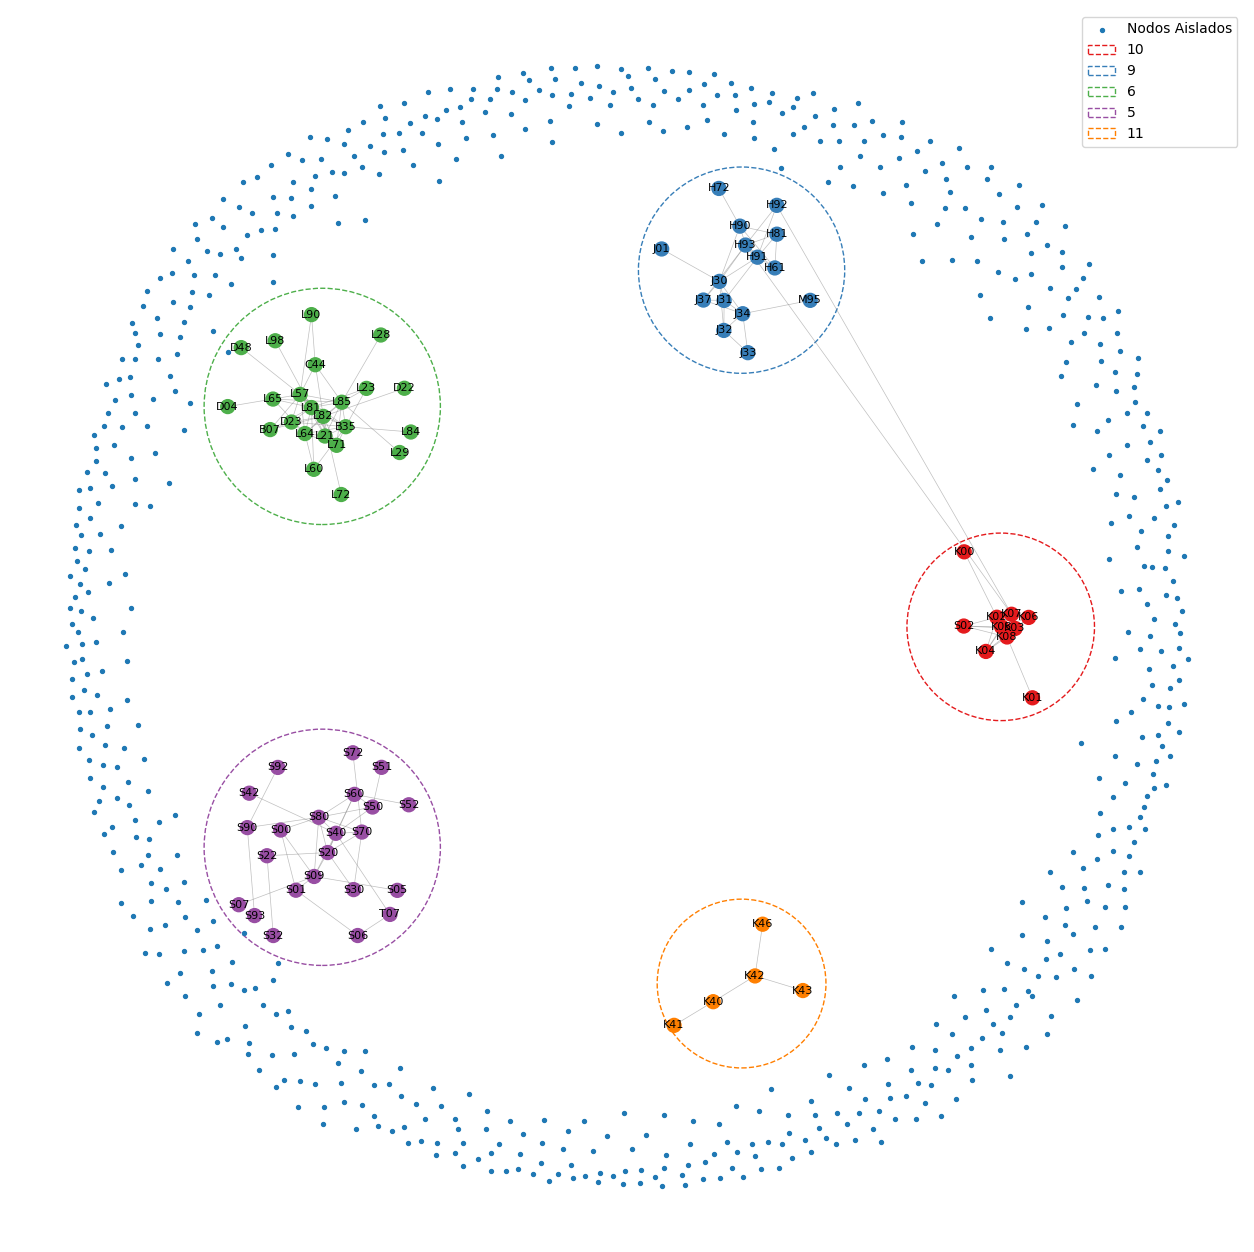

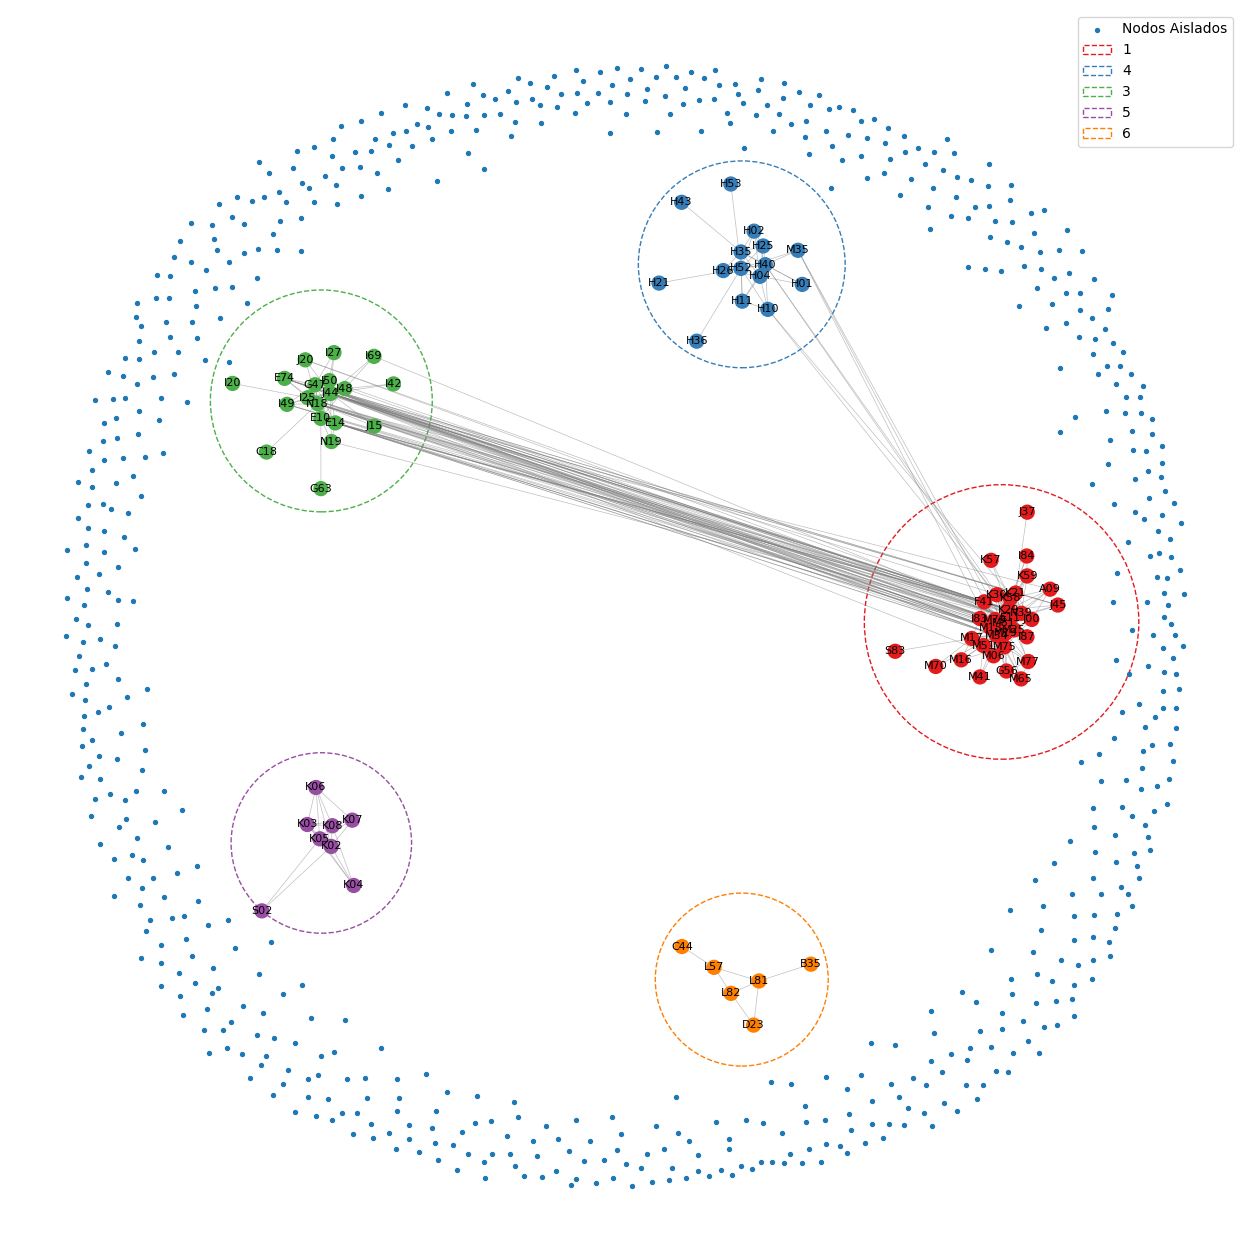

In [8]:
generate_results('redes/graph_sci_F1_60.graphml','redes/graph_cij_F1_60.graphml',label = 'Femenino Subsidiado > 60')

### Femenino Contributivo >60

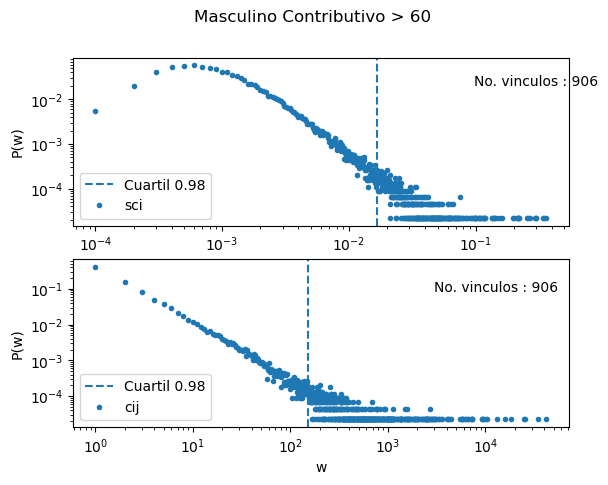

Numero nodos iniciales :  1292
Numero vinculos iniciales :  45162
Numero nodos finales:  342
Numero vinculos finales :  904
Modularidad
0.5941189355078706
Numero nodos iniciales :  1292
Numero vinculos iniciales :  45162
Numero nodos finales:  218
Numero vinculos finales :  906
Modularidad
0.3123918785238464


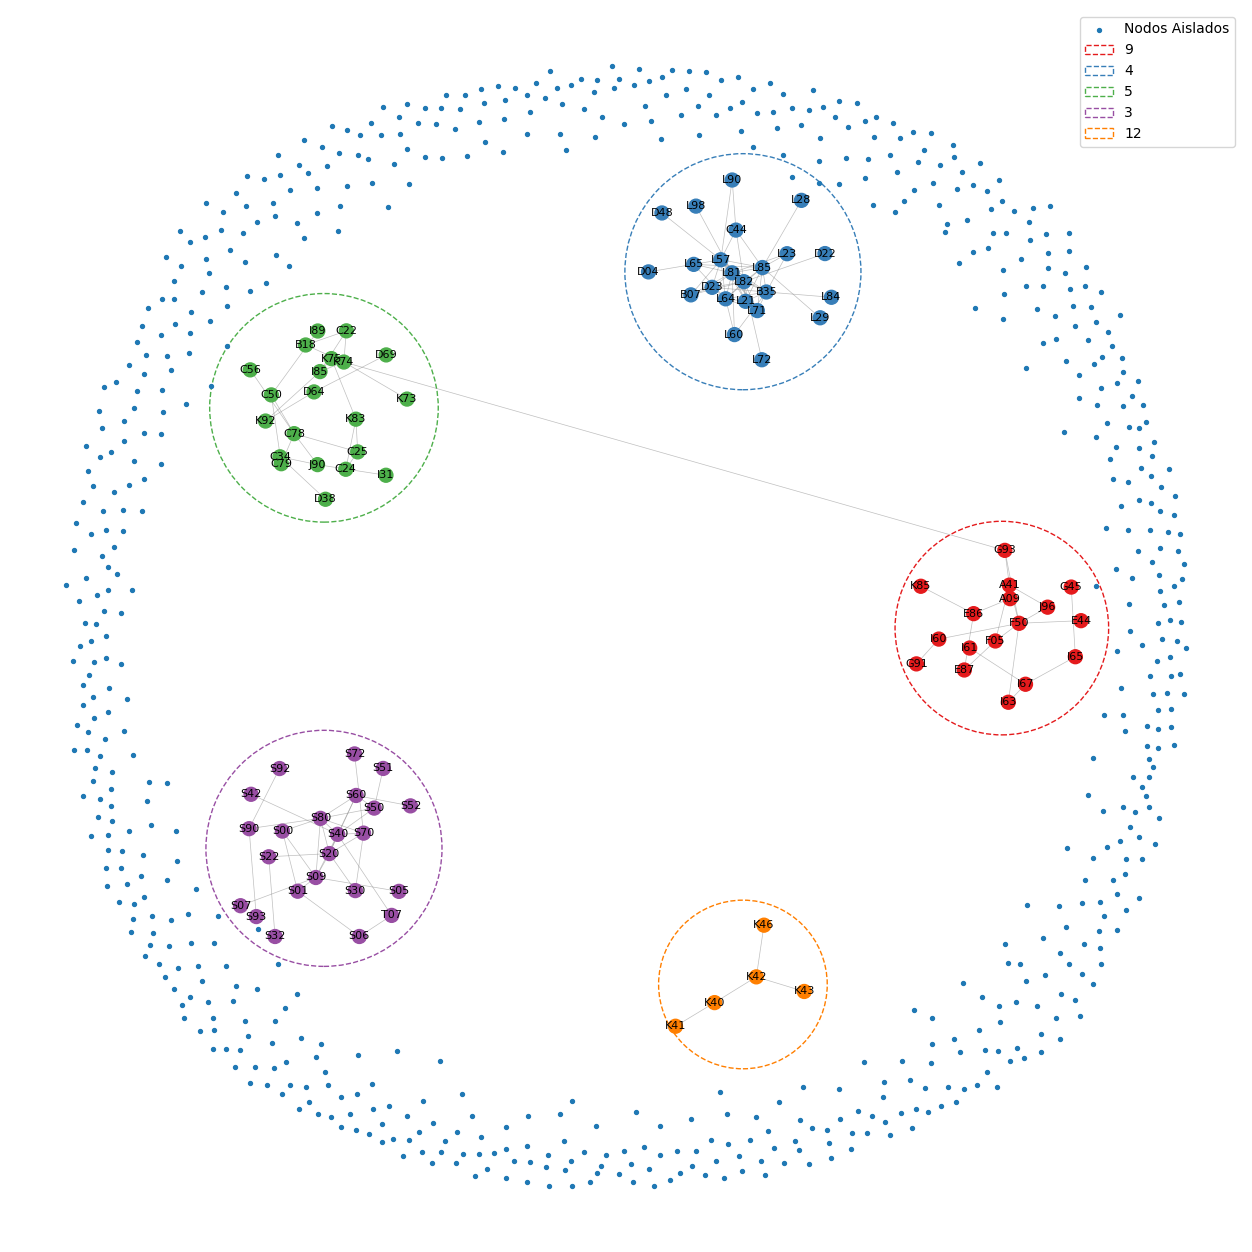

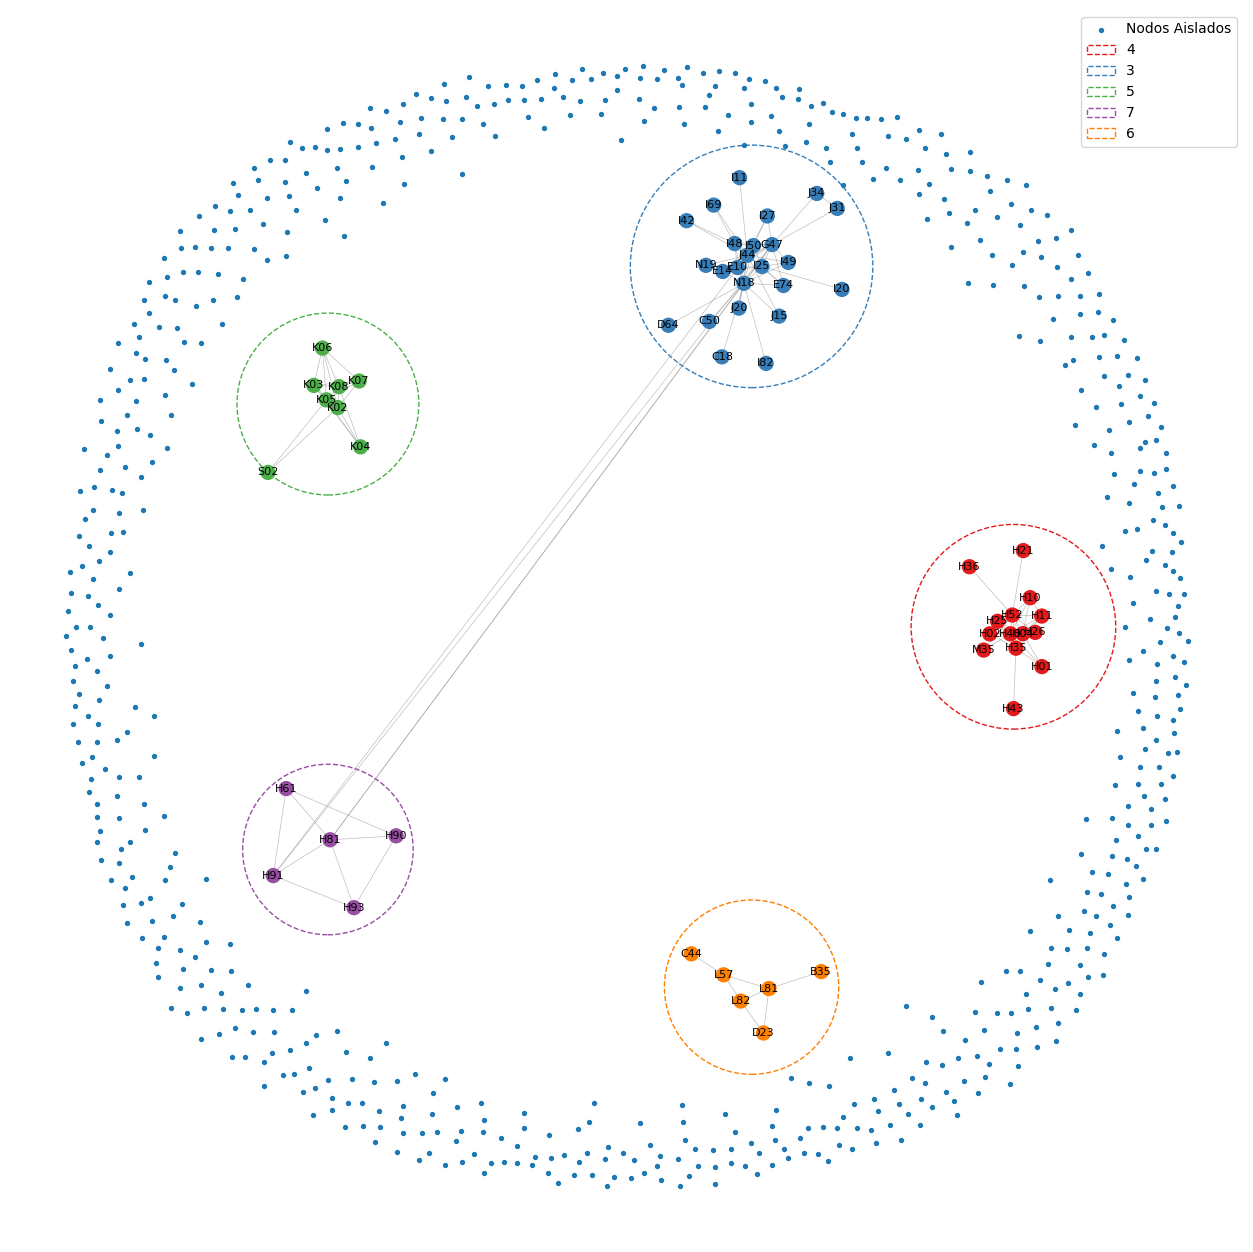

In [9]:
generate_results('redes/graph_sci_F1_60.graphml','redes/graph_cij_F1_60.graphml',label = 'Masculino Contributivo > 60')

### Masculino Subsidiado 40-60

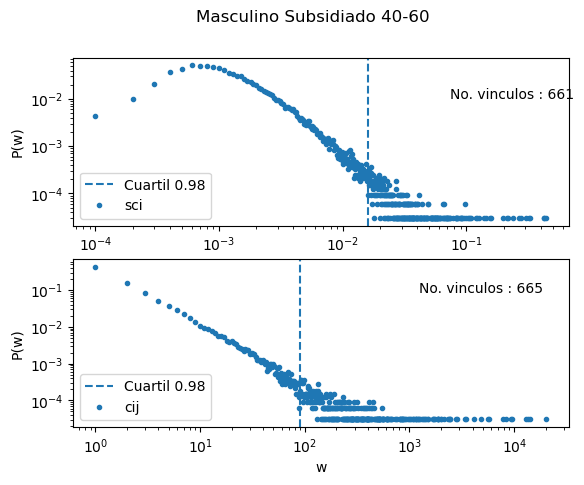

Numero nodos iniciales :  1257
Numero vinculos iniciales :  33036
Numero nodos finales:  340
Numero vinculos finales :  661
Modularidad
0.7174763858912713
Numero nodos iniciales :  1257
Numero vinculos iniciales :  33036
Numero nodos finales:  155
Numero vinculos finales :  665
Modularidad
0.3050460738311945


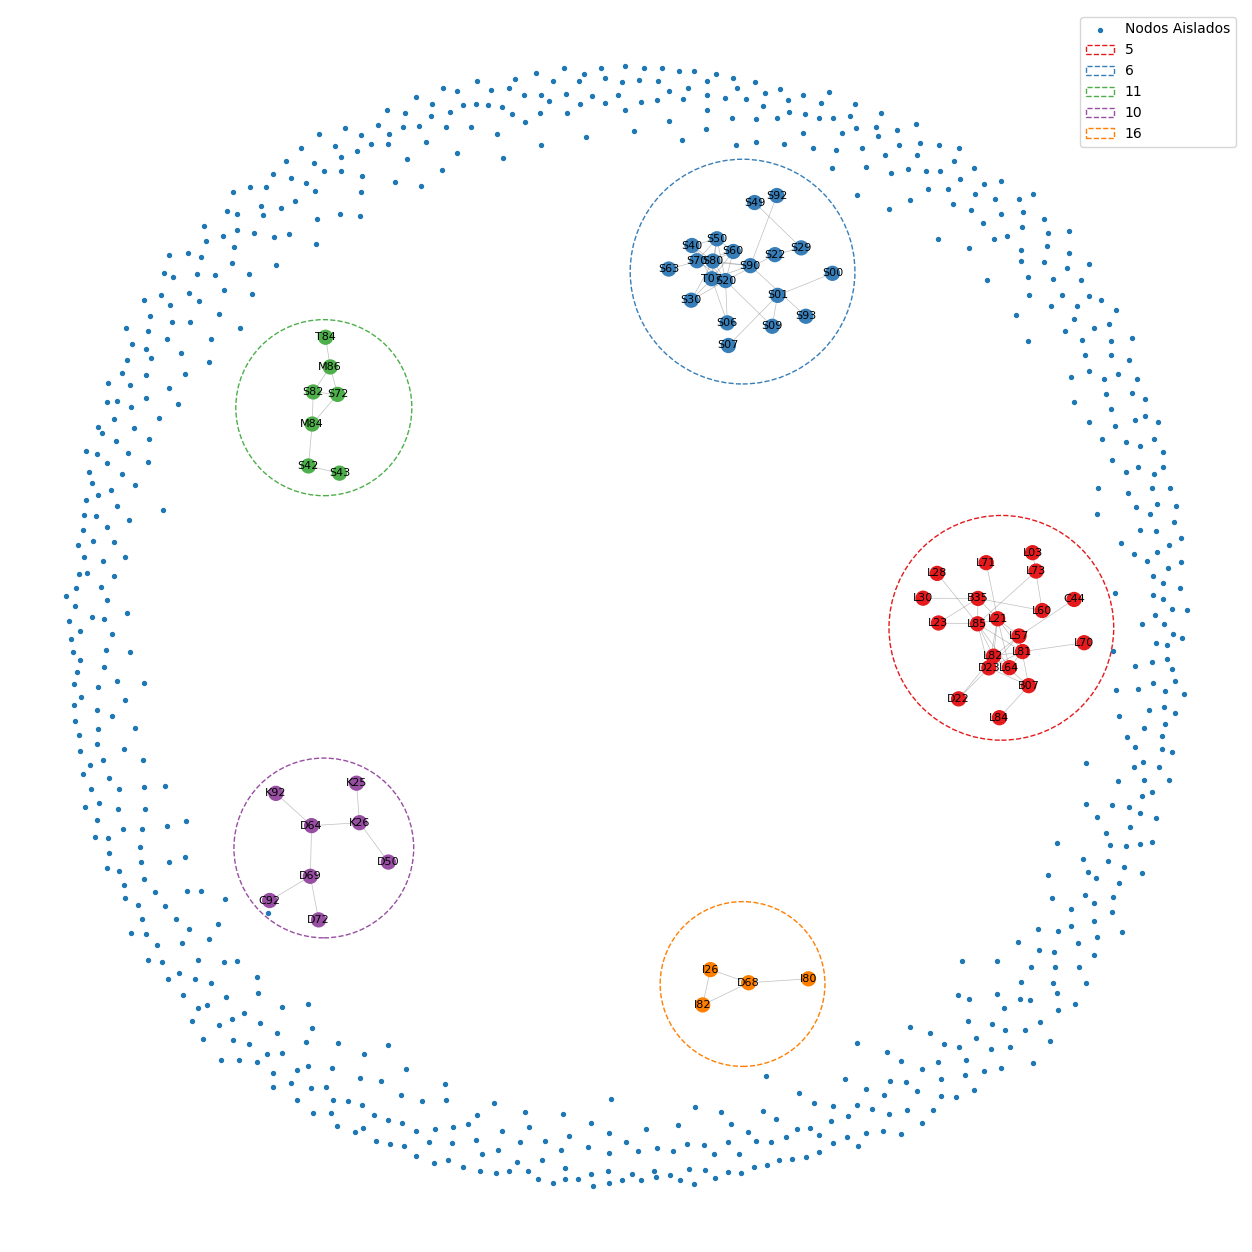

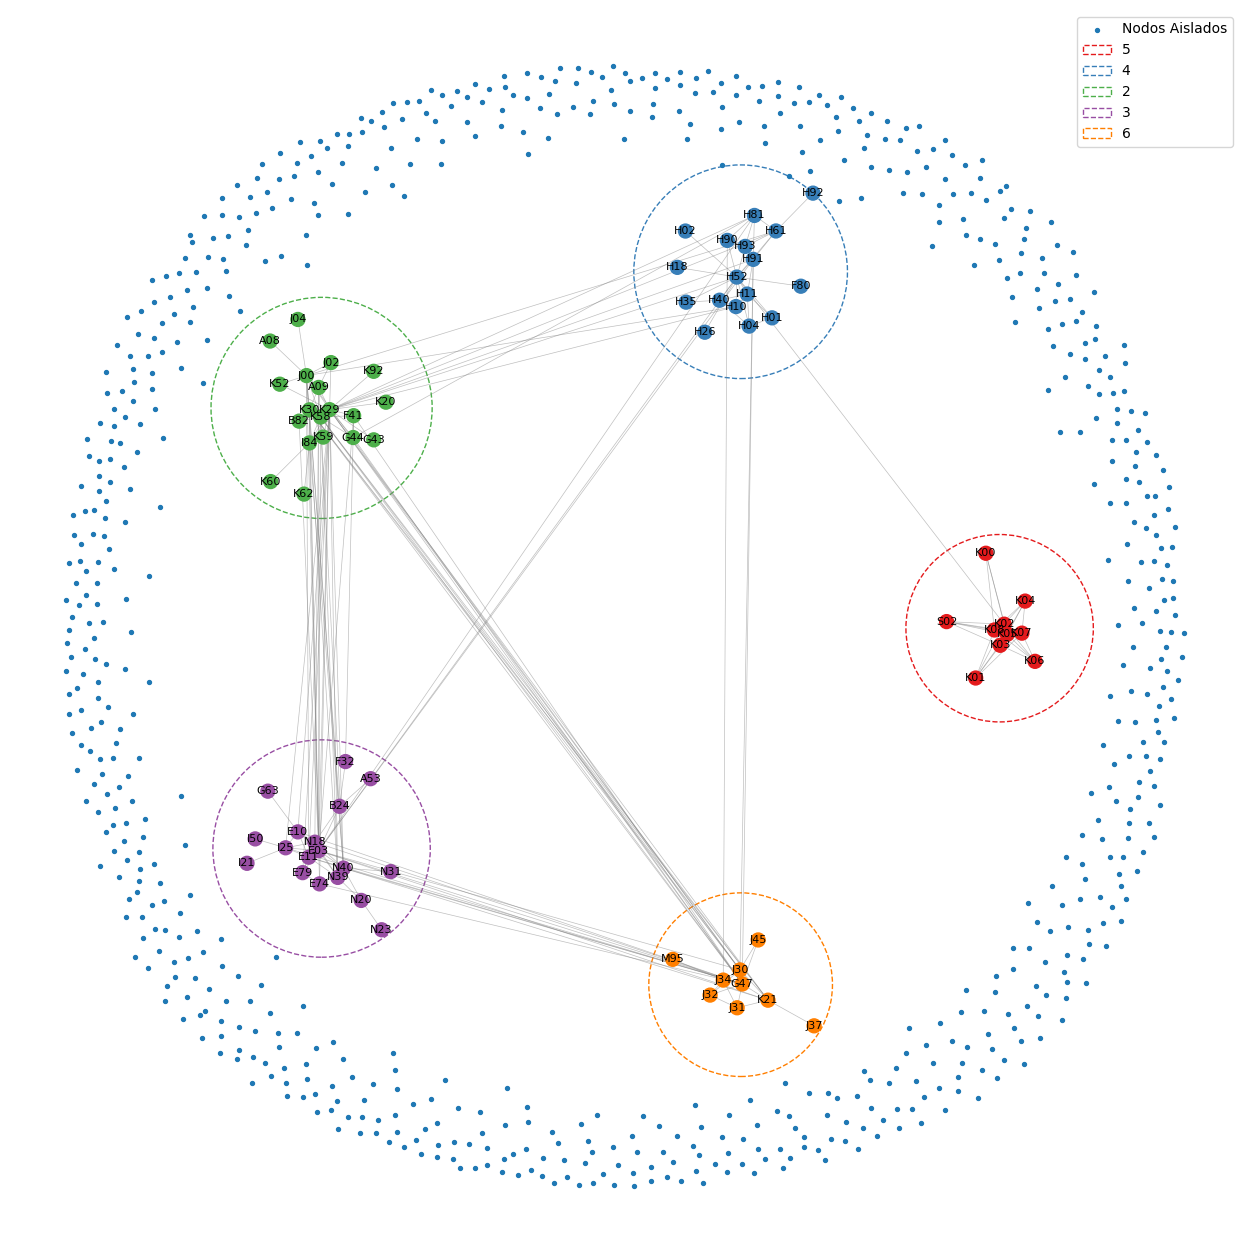

In [10]:
generate_results('redes/graph_sci_M1_40.graphml','redes/graph_cij_M1_40.graphml',label = 'Masculino Subsidiado 40-60')

### Masculino Contriubutivo 40-60

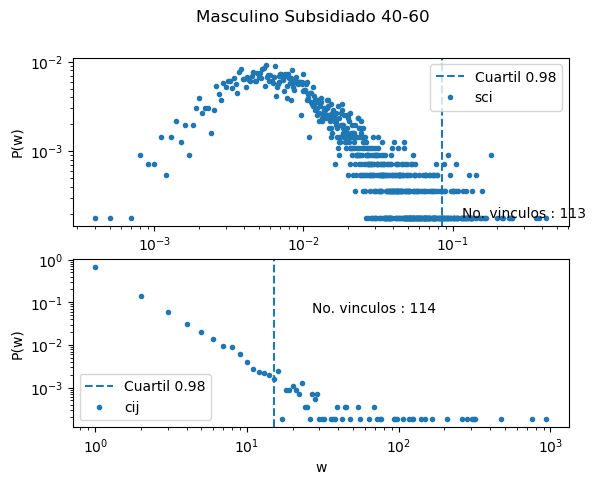

Numero nodos iniciales :  956
Numero vinculos iniciales :  5575
Numero nodos finales:  147
Numero vinculos finales :  113
Modularidad
0.9465502388597372
Numero nodos iniciales :  956
Numero vinculos iniciales :  5575
Numero nodos finales:  59
Numero vinculos finales :  114
Modularidad
0.4446752847029856


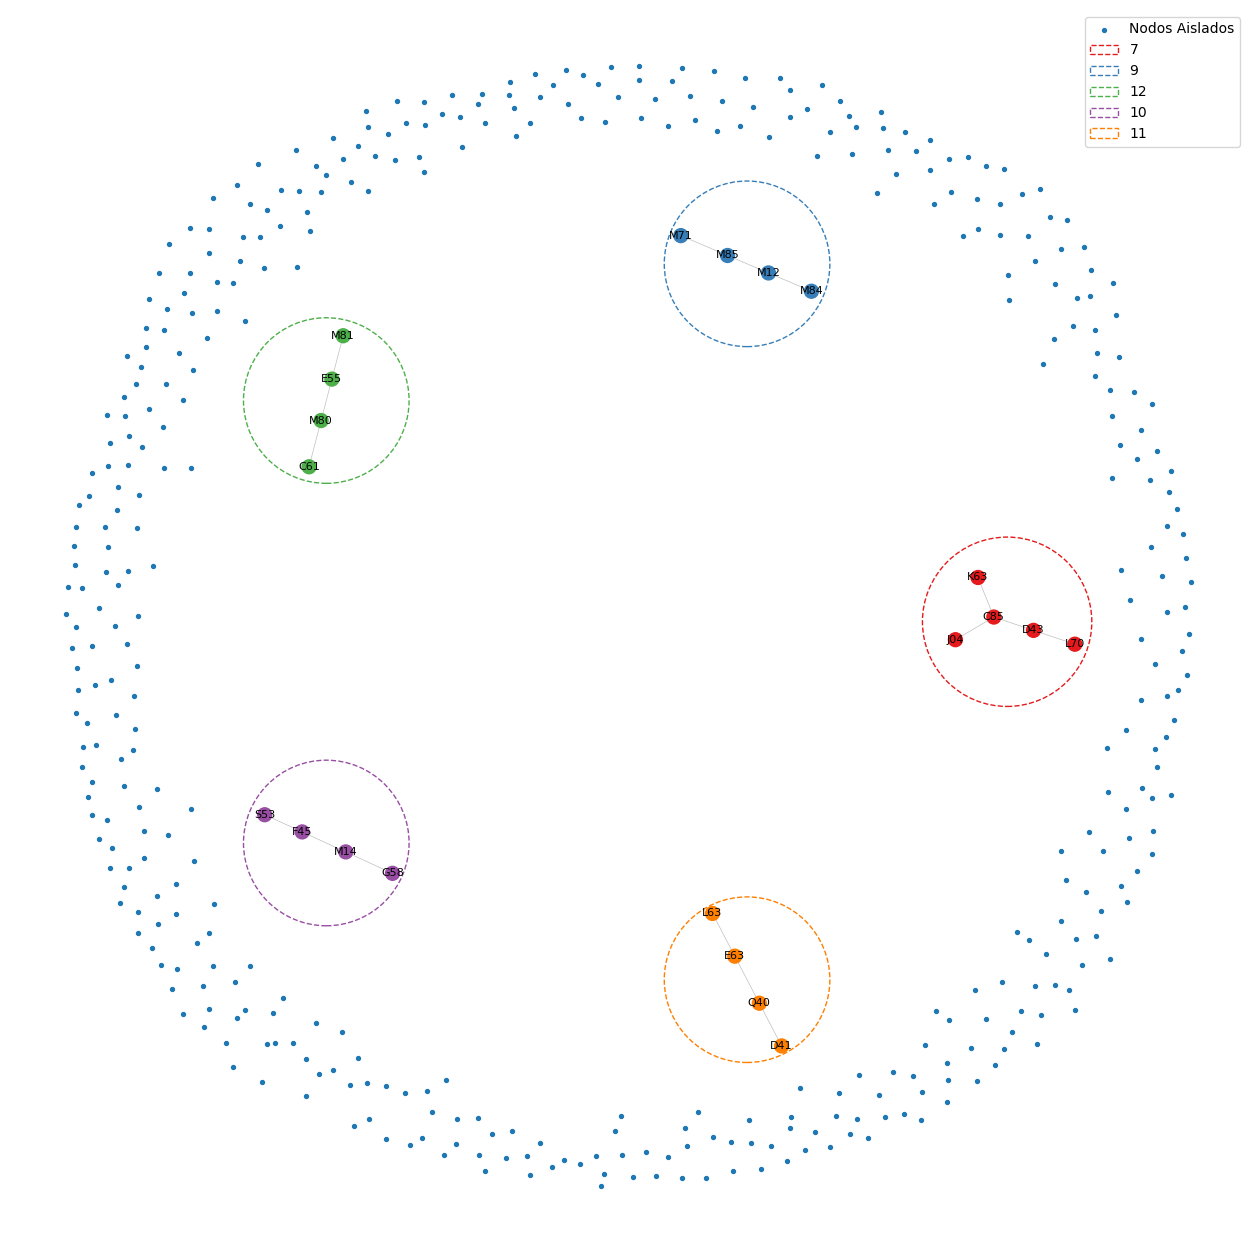

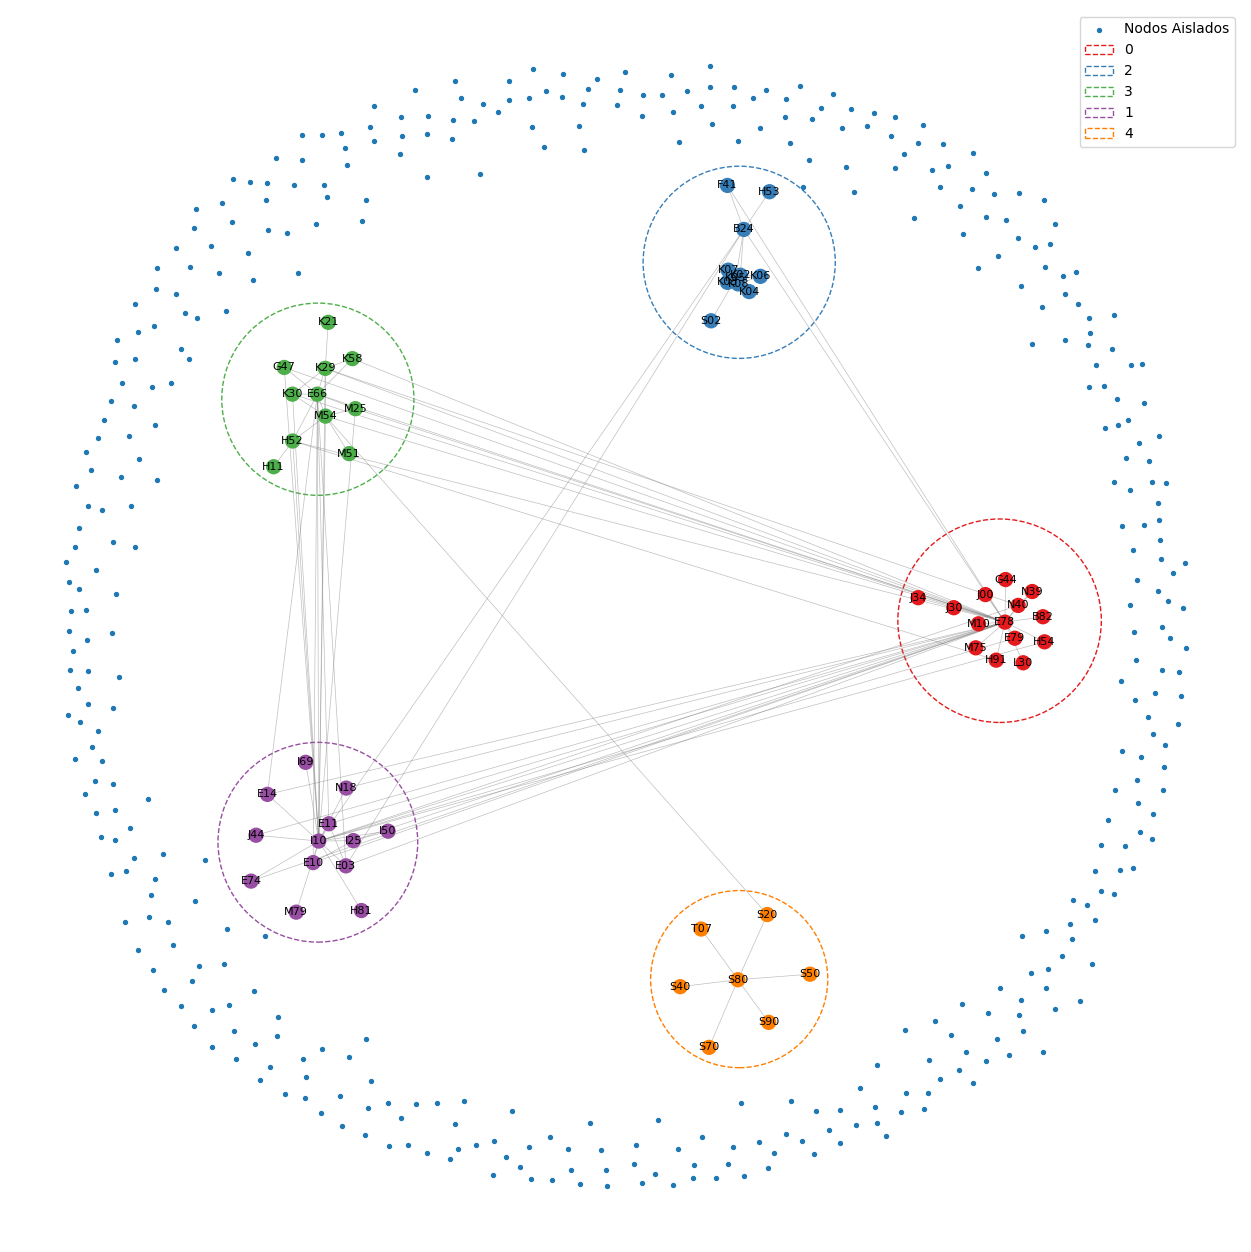

In [11]:
generate_results('redes/graph_sci_M2_40.graphml','redes/graph_cij_M2_40.graphml',label = 'Masculino Subsidiado 40-60')

### Masculino Subsidiado >60

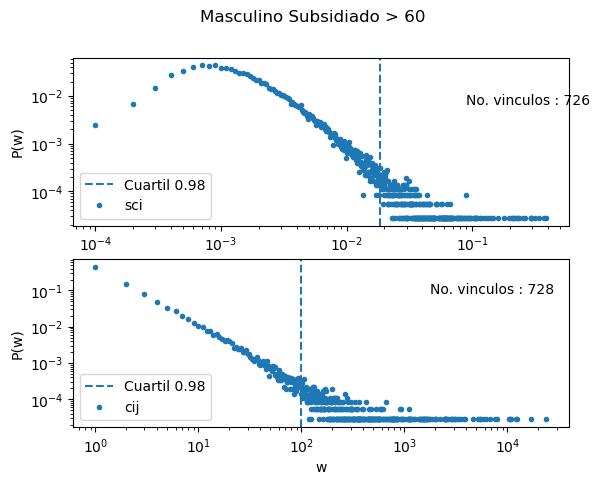

Numero nodos iniciales :  1258
Numero vinculos iniciales :  36197
Numero nodos finales:  337
Numero vinculos finales :  724
Modularidad
0.6766353285919234
Numero nodos iniciales :  1258
Numero vinculos iniciales :  36197
Numero nodos finales:  197
Numero vinculos finales :  728
Modularidad
0.33294778710300693


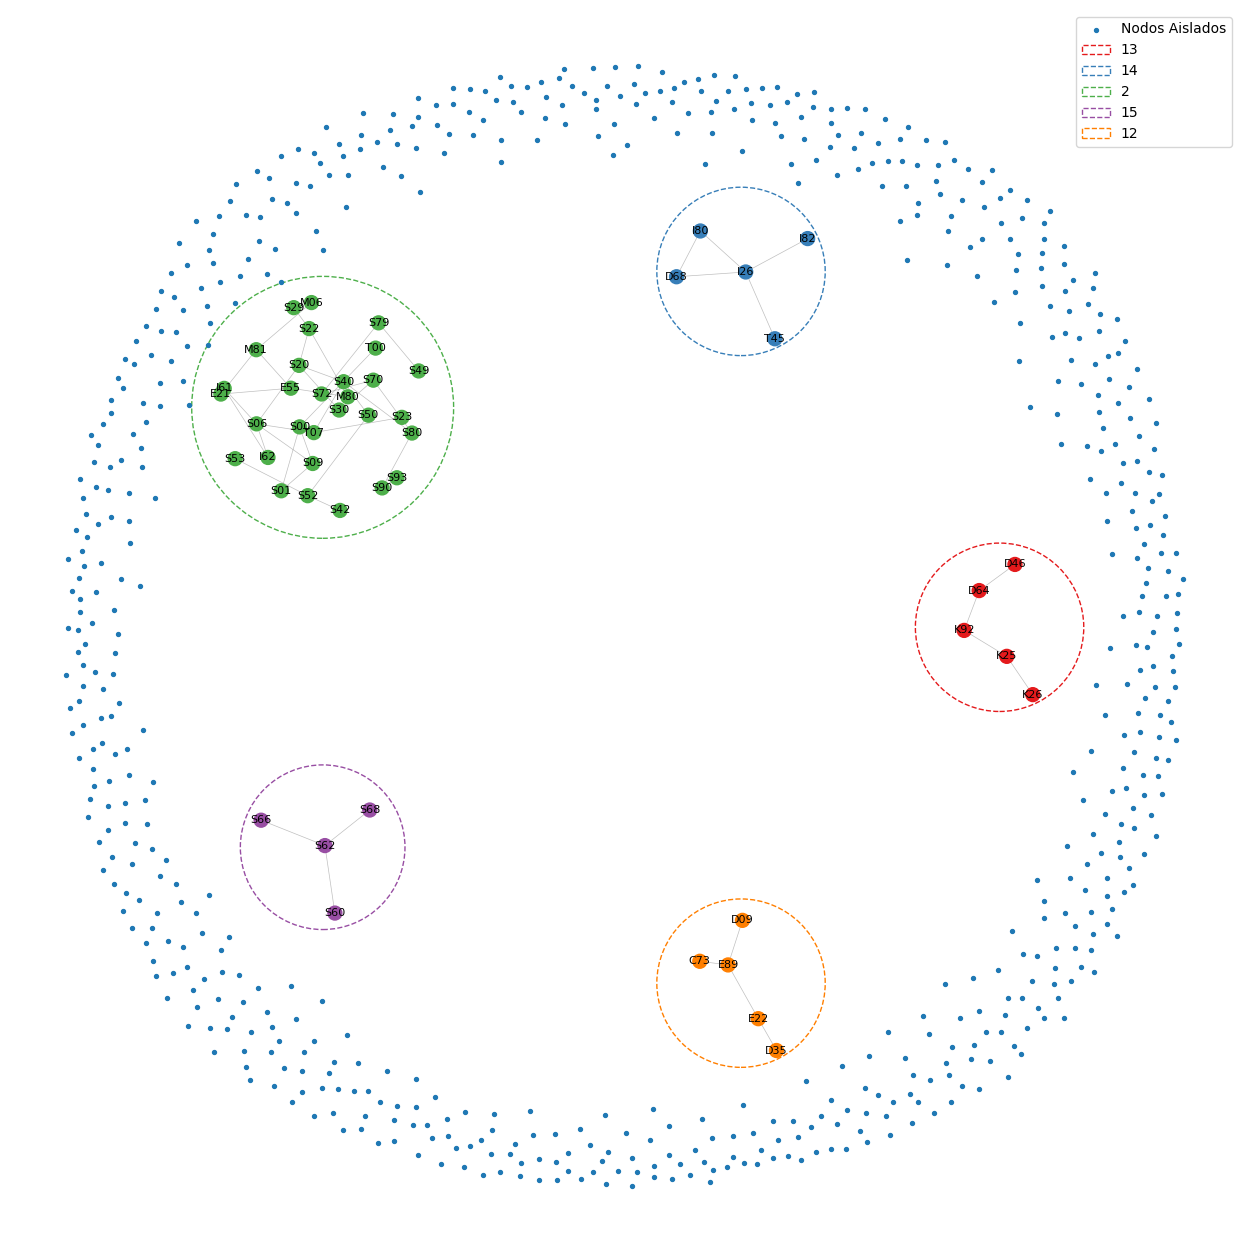

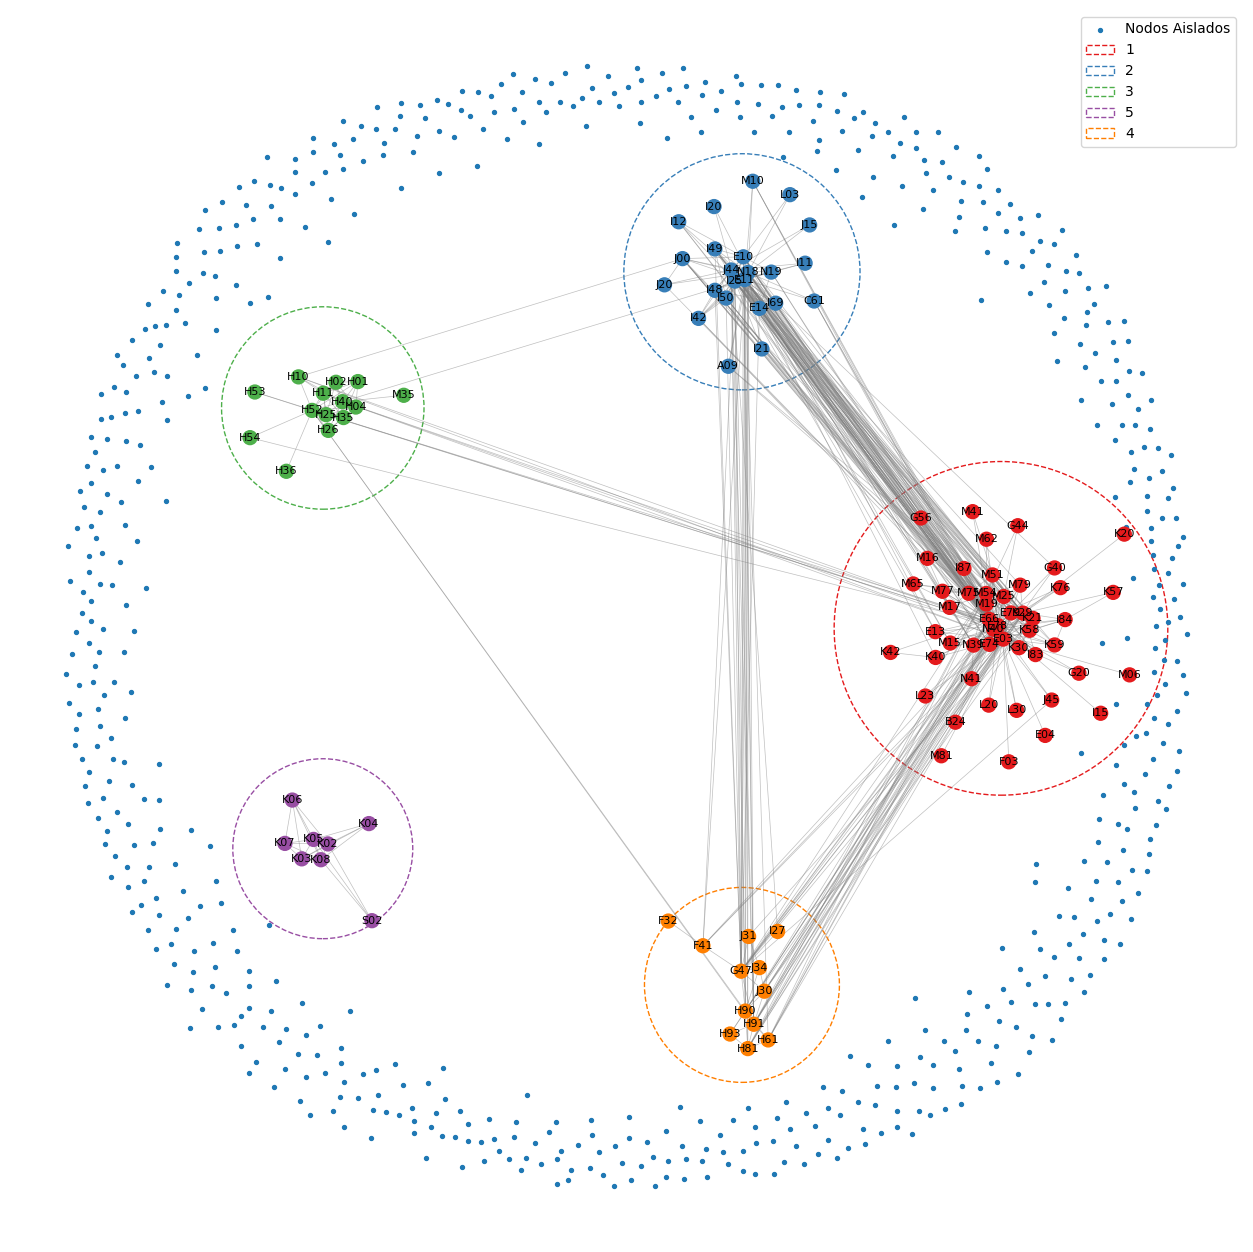

In [12]:
generate_results('redes/graph_sci_M1_60.graphml','redes/graph_cij_M1_60.graphml',label = 'Masculino Subsidiado > 60')

### Masculino Contributivo >60

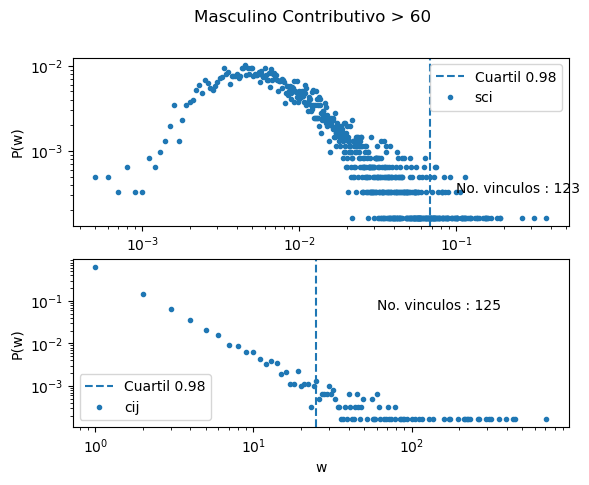

Numero nodos iniciales :  909
Numero vinculos iniciales :  6118
Numero nodos finales:  139
Numero vinculos finales :  123
Modularidad
0.8970520193006816
Numero nodos iniciales :  909
Numero vinculos iniciales :  6118
Numero nodos finales:  57
Numero vinculos finales :  125
Modularidad
0.36790400000000006


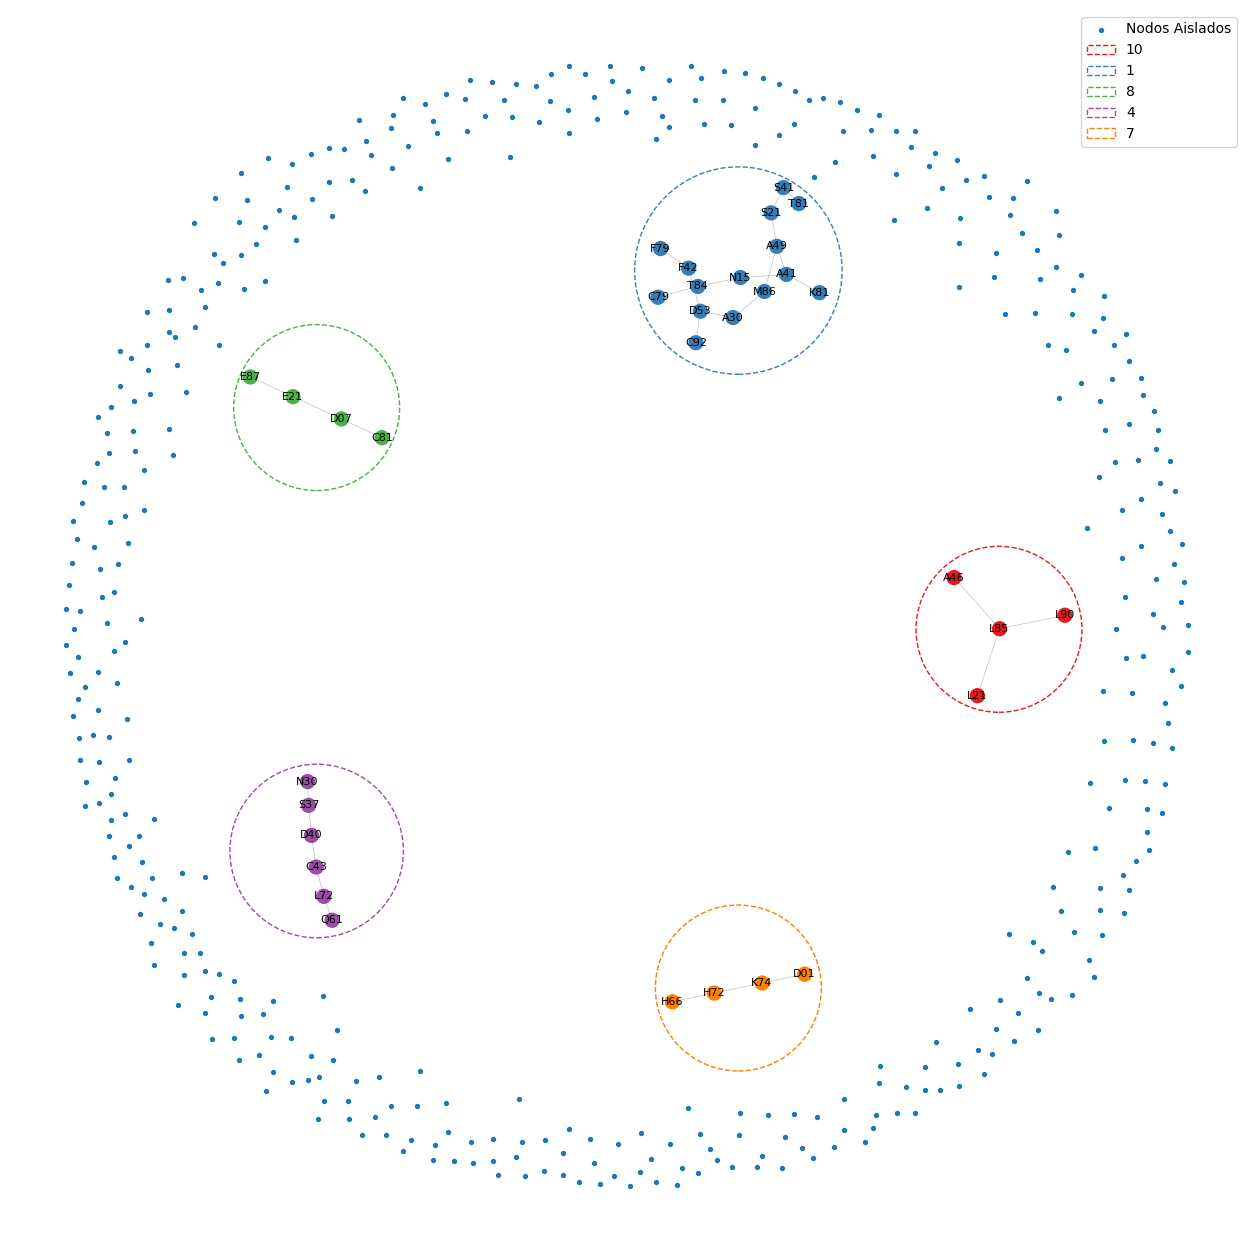

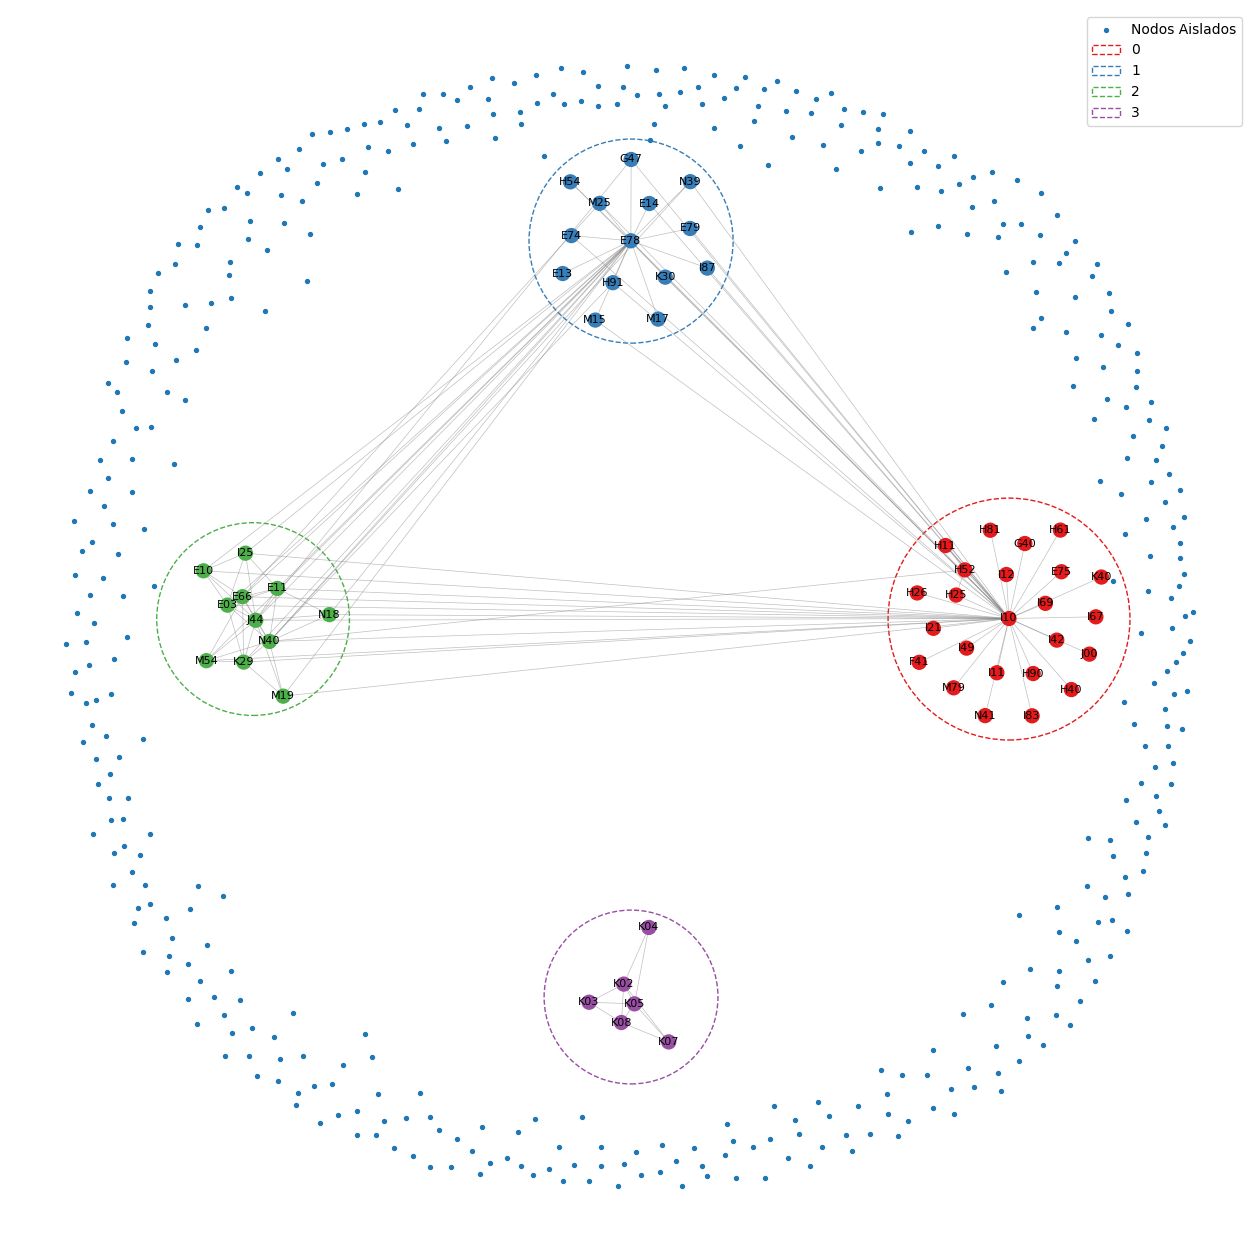

In [13]:
generate_results('redes/graph_sci_M2_60.graphml','redes/graph_cij_M2_60.graphml',label = 'Masculino Contributivo > 60')